In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

overwrite_figures = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [111]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (256,256,128),
            baseline = (1500, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
wire = tissue.Tissue(name='wire', c=2400, rho=1500, sigma=0, scale=0.001, label=1)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

wire_mask = np.zeros(test_phantom.matrix_dims)
for i in range(3,8): # horizontal near
    wire_mask[int(0.01/test_phantom.voxel_dims[0]*4),int(0.01/test_phantom.voxel_dims[0]*i),:] = 1
for i in range(3,8): # horizontal mid
    wire_mask[int(0.01/test_phantom.voxel_dims[0]*8),int(0.01/test_phantom.voxel_dims[0]*i),:] = 1
for i in range(3,8): # horizontal far
    wire_mask[int(0.01/test_phantom.voxel_dims[0]*12),int(0.01/test_phantom.voxel_dims[0]*i),:] = 1
for i in range(4,12): # vertical
    wire_mask[int(0.01/test_phantom.voxel_dims[0]*i),int(0.01/test_phantom.voxel_dims[0]*6),:] = 1

for i in range(0,7): # far sweep
    wire_mask[120, 180 - int((0.001 / test_phantom.voxel_dims[0] * i) ** 1.5),:] = 1
    wire_mask[118 - int((0.0007 / test_phantom.voxel_dims[0] * (6-i)) ** 1.5), 180 - int((0.001 / test_phantom.voxel_dims[0] * i) ** 1.5),:] = 1
    
for i in range(0,7): # far sweep
    wire_mask[200, 180 - int((0.001 / test_phantom.voxel_dims[0] * i) ** 1.5),:] = 1
    wire_mask[198 - int((0.0007 / test_phantom.voxel_dims[0] * (6-i)) ** 1.5), 180 - int((0.001 / test_phantom.voxel_dims[0] * i) ** 1.5),:] = 1
    
test_phantom.add_tissue(wire, mask=wire_mask)
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

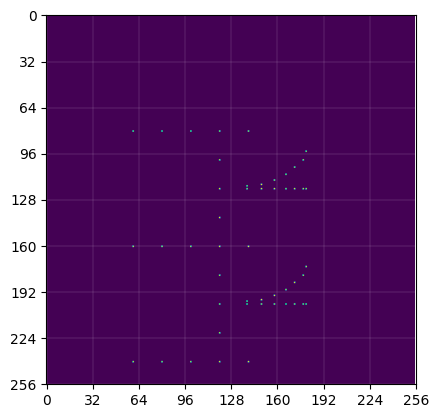

In [112]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [113]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=2e6,
                                    elements = 256, 
                                    width = 40e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5,
                                    imaging_ndims = 2,
                                    focus_elevation = 100e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

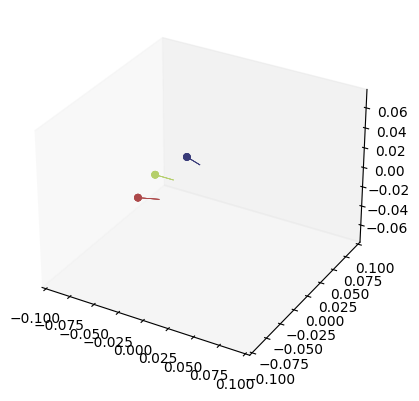

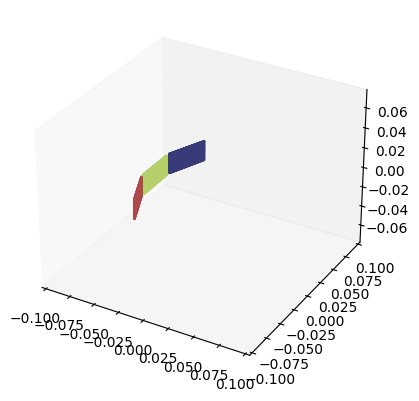

In [114]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([-np.pi/8,0,0], [-0.042,0.042,0]))
cont_transducer_set.assign_pose(1, geometry.Transform([0,0,0], [-0.05,0,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([np.pi/8,0,0], [-0.042,-0.042,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

In [115]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')

In [116]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,110e-3,30e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [117]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'synchronous_aperture_resolution',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'sequential_aperture_resolution',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

extended_experiment.save()
tar_experiment.save()

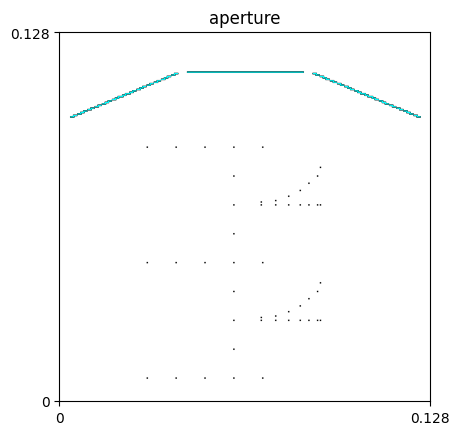

In [121]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2+1])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,256])
plt.gca().set_xticklabels(['0','0.128'])
plt.gca().set_yticks([0,256])
plt.gca().set_yticklabels(['0.128','0'])
plt.savefig('resolution_phantom.png', dpi=300, bbox_inches="tight")

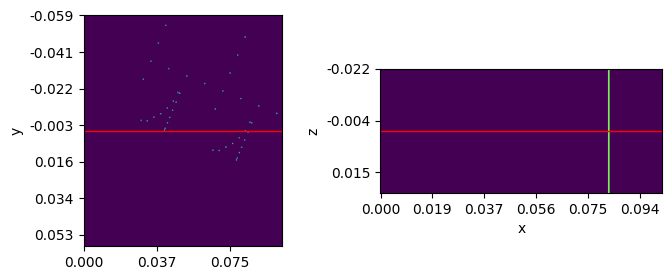

In [120]:
extended_experiment.plot_ray_path(0)

In [122]:
test_experiment = experiment.Experiment.load('sequential_aperture_resolution')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

running with 3 workers



preparation for sim    0 completed in 78.31 seconds
preparation for sim    8 completed in 78.95 seconds
preparation for sim    1 completed in 80.43 seconds
preparation for sim    9 completed in 79.27 seconds
simulation             0 completed in 364.43 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             8 completed in 360.73 seconds
preparation for sim    2 completed in 75.71 seconds
preparation for sim   10 completed in 76.65 seconds
simulation             1 completed in 363.88 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             9 completed in 360.60 seconds
preparation for sim   11 completed in 76.82 seconds
preparation for sim    3 completed in 75.95 seconds
simu

In [123]:
test_experiment = experiment.Experiment.load('synchronous_aperture_resolution')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

running with 3 workers



preparation for sim    0 completed in 78.43 seconds
preparation for sim    8 completed in 79.23 seconds
preparation for sim    1 completed in 79.41 seconds
preparation for sim    9 completed in 82.26 seconds
simulation             0 completed in 360.95 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             8 completed in 360.64 seconds
preparation for sim    2 completed in 75.84 seconds
preparation for sim   10 completed in 112.30 seconds
simulation             1 completed in 360.52 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation             9 completed in 361.74 seconds
preparation for sim   11 completed in 76.12 seconds
preparation for sim    3 completed in 75.65 seconds
sim

# Reconstruction

In [3]:
test_experiment = experiment.Experiment.load('sequential_aperture_resolution')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 3/3 [01:05<00:00, 21.81s/it]


In [4]:
images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 15/15 [00:00<00:00, 332881.27it/s]


In [5]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)/(len(images1)//3)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)/(len(images1)//3)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)/(len(images1)//3)

In [6]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,228:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:228] = 0
sensor_mask2[:,456:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:456] = 0

100%|██████████| 256/256 [00:00<00:00, 2460.68it/s]


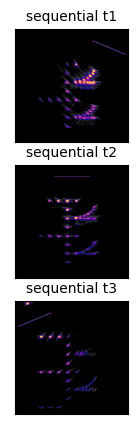

In [7]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

# psf = 20 * np.log10(image1t1 / 1000000)
psf = 20 * np.log10(image1t1 / np.max(image1t1))

image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[0].set_title('sequential t1', fontsize=10)

# psf = 20 * np.log10(image1t2 / 1000000)
psf = 20 * np.log10(image1t2 / np.max(image1t2))
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[1].set_title('sequential t2', fontsize=10)

# psf = 20 * np.log10(image1t3 / 1000000)
psf = 20 * np.log10(image1t3 / np.max(image1t3))
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[2].set_title('sequential t3', fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_individual_resolution.png', dpi=300, bbox_inches="tight")

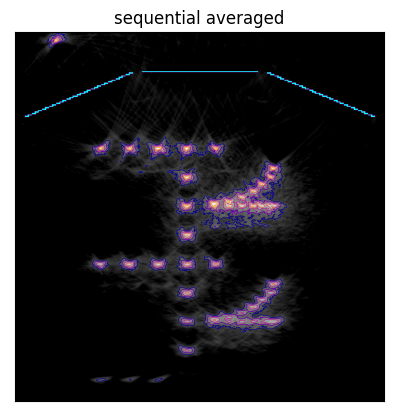

In [8]:
# psf = 20 * np.log10(image1 / 1000000)
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-35, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5,0])

ax.set_title('sequential averaged')

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_resolution.png', dpi=300, bbox_inches="tight")

In [9]:
test_experiment = experiment.Experiment.load('synchronous_aperture_resolution')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 3/3 [00:49<00:00, 16.66s/it]


In [10]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 15/15 [00:00<00:00, 302473.85it/s]


In [11]:
image2 = np.sum(images2, axis=0)/len(images2)
image2t1 = np.sum(images2[:len(images2)//3], axis=0)/(len(images2)//3)
image2t2 = np.sum(images2[len(images2)//3:2*len(images2)//3], axis=0)/(len(images2)//3)
image2t3 = np.sum(images2[2*len(images2)//3:], axis=0)/(len(images2)//3)


In [12]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,228:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:228] = 0
sensor_mask2[:,456:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:456] = 0

100%|██████████| 256/256 [00:00<00:00, 2508.43it/s]


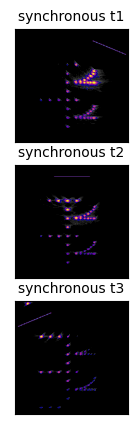

In [13]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

# psf = 20 * np.log10(image2t1 / 1000000)
psf = 20 * np.log10(image2t1 / np.max(image2t1))
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[0].set_title('synchronous t1', fontsize=10)

# psf = 20 * np.log10(image2t2 / 1000000)
psf = 20 * np.log10(image2t2 / np.max(image2t2))
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[1].set_title('synchronous t2', fontsize=10)

# psf = 20 * np.log10(image2t3 / 1000000)
psf = 20 * np.log10(image2t3 / np.max(image2t3))
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[2].set_title('synchronous t3', fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('synchronous_aperture_individual_resolution.png', dpi=300, bbox_inches="tight")

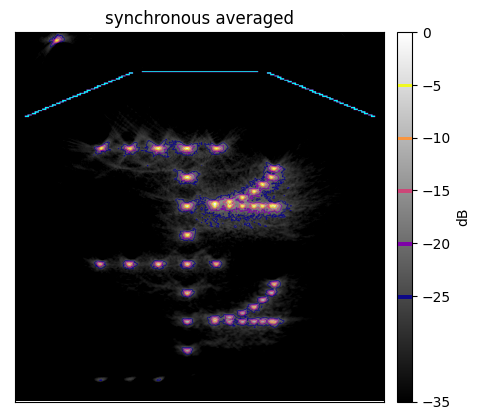

In [14]:
# psf = 20 * np.log10(image2 / 1000000)
psf = 20 * np.log10(image2 / np.max(image2))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-35, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])

ax.set_title('synchronous averaged')

plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-35,-25,-20,-15,-10,-5,0])
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
plt.legend(proxy[::-1], ['','','','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.905), labelspacing = 2.8)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('synchronous_aperture_resolution.png', dpi=300, bbox_inches="tight")

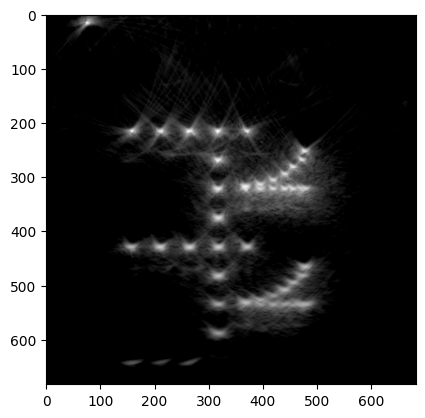

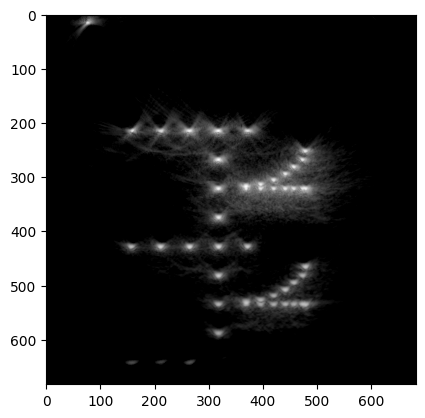

In [15]:
psf = 20 * np.log10(image1 / np.max(image1))
psf_image1 = psf[:,:,psf.shape[2]//2]

plt.imshow(psf_image1, cmap='gray', vmin=-35, vmax=0)
plt.show()
psf = 20 * np.log10(image2 / np.max(image2))
psf_image2 = psf[:,:,psf.shape[2]//2]

plt.imshow(psf_image2, cmap='gray', vmin=-35, vmax=0)
plt.show()

In [215]:
np.where(np.sum(test_reconstruction.phantom.mask, axis=(1,2))>128)

(array([ 80, 100, 120, 160, 180, 200, 240]),)

[320 370 397 421 442 458 474 480]
606.5225568924058 430


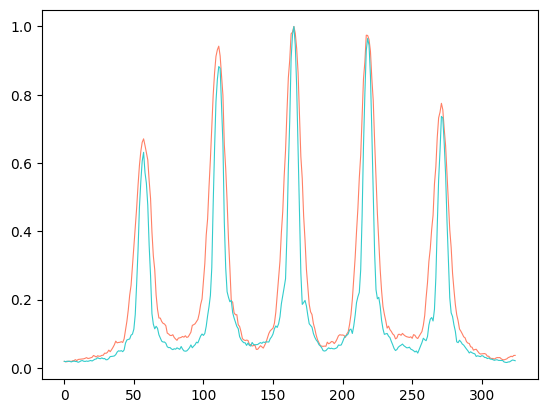

In [216]:
# mid horizontal

res_horz_indices = np.array([120, 139, 149, 158, 166, 172, 178, 180])
res_horz_indices = res_horz_indices * 683 // 256
print(res_horz_indices)

max = 0
index = 428
for i in range(400,450):
    if np.max(image1[i]) > max:
        max = np.max(image1[i])
        index = i
print(max, index)

# plt.plot(image1[index] / np.max(image1[index])) # sequential
# plt.plot(image2[index] / np.max(image2[index])) # synchronous

plt.plot(image1[index,100:425] / np.max(image1[index,100:425]), linewidth = 0.8, c = [1,0.5,0.4]) # sequential
plt.plot(image2[index,100:425] / np.max(image2[index,100:425]), linewidth = 0.8, c=[0.2,0.8,0.8]) # synchronous

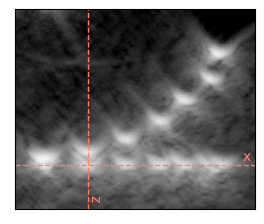

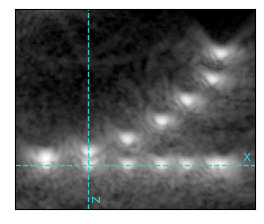

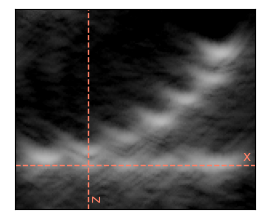

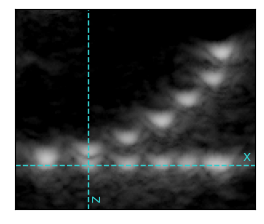

In [124]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[225:350,350:500,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=97, color=[1,0.5,0.4], linewidth=1, linestyle='--')
plt.axvline(x=45, color=[1,0.5,0.4], linewidth=1, linestyle='--')
plt.text(45,118,'z',rotation=-90, color=[1,0.5,0.4])
plt.text(142,94,'x', color=[1,0.5,0.4])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('resolution_near_horizontal_sequential.png', dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(1,1, figsize=(3,2))
psf = 20 * np.log10(image2 / np.max(image2))
image = psf[225:350,350:500,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=97, color=[0.2,0.8,0.8], linewidth=1, linestyle='--')
plt.axvline(x=45, color=[0.2,0.8,0.8], linewidth=1, linestyle='--')
plt.text(45,118,'z',rotation=-90, color=[0.2,0.8,0.8])
plt.text(142,94,'x', color=[0.2,0.8,0.8])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('resolution_near_horizontal_synchronous.png', dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(1,1, figsize=(3,2))
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[439:564,350:500,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=97, color=[1,0.5,0.4], linewidth=1, linestyle='--')
plt.axvline(x=45, color=[1,0.5,0.4], linewidth=1, linestyle='--')
plt.text(45,118,'z',rotation=-90, color=[1,0.5,0.4])
plt.text(142,94,'x', color=[1,0.5,0.4])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('resolution_far_horizontal_sequential.png', dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(1,1, figsize=(3,2))
psf = 20 * np.log10(image2 / np.max(image2))
image = psf[439:564,350:500,psf.shape[2]//2]
plt.imshow(image, cmap='gray', vmin=-35, vmax=0)
plt.axhline(y=97, color=[0.2,0.8,0.8], linewidth=1, linestyle='--')
plt.axvline(x=45, color=[0.2,0.8,0.8], linewidth=1, linestyle='--')
plt.text(45,118,'z',rotation=-90, color=[0.2,0.8,0.8])
plt.text(142,94,'x', color=[0.2,0.8,0.8])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig('resolution_far_horizontal_synchronous.png', dpi=300, bbox_inches="tight")

In [86]:
res_horz_indices = np.array([139, 149, 158, 166, 172, 178, 180])
res_horz_indices = res_horz_indices * 683 // 256
res_vert_indices1 = np.array([114, 117])
res_vert_indices1 = res_vert_indices1 * 683 // 256
res_vert_indices2 = np.array([194, 197])
res_vert_indices2 = res_vert_indices2 * 683 // 256

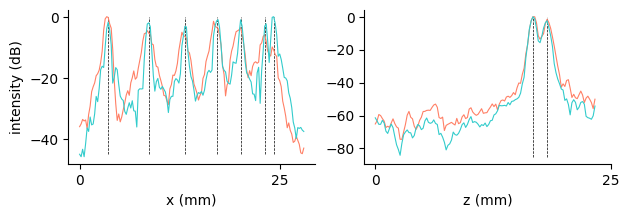

In [82]:
# near resolution horizontal
fig, ax = plt.subplots(1,2, figsize=(7,2))
index = 324
for xc in res_horz_indices:
    ax[0].vlines(x=xc-351, ymin=-45,ymax=0, linewidth=0.5, color='k', linestyle='--')
ax[0].plot(20*np.log(image1[index,350:500] / np.max(image1[index,350:500])), linewidth = 0.8, c = [1,0.5,0.4], label='sequential')
ax[0].plot(20*np.log(image2[index,350:500] / np.max(image2[index,350:500])), linewidth = 0.8, c=[0.2,0.8,0.8], label='synchronous')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel('intensity (dB)')
ax[0].set_xticks([0,133]) # 133 / 683 * 256 * 0.5
ax[0].set_xticklabels(['0','25'])
ax[0].set_xlabel('x (mm)')

index = 395
for xc in res_vert_indices1:
    ax[1].vlines(x=xc-215, ymin=-85,ymax=0, linewidth=0.5, color='k', linestyle='--')
ax[1].plot(20*np.log(image1[225:350,index] / np.max(image1[225:350,index])), linewidth = 0.8, c = [1,0.5,0.4], label='sequential')
ax[1].plot(20*np.log(image2[225:350,index] / np.max(image2[225:350,index])), linewidth = 0.8, c=[0.2,0.8,0.8], label='synchronous')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# ax[1].set_ylabel('intensity (dB)')
ax[1].set_xticks([0,133]) # 133 / 683 * 256 * 0.5
ax[1].set_xticklabels(['0','25'])
ax[1].set_xlabel('z (mm)')

plt.savefig('resolution_near_horizontal_psf.png', dpi=300, bbox_inches="tight")

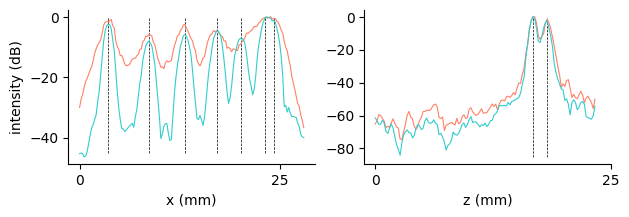

In [99]:
# far resolution horizontal
fig, ax = plt.subplots(1,2, figsize=(7,2))
index = 535
for xc in res_horz_indices:
    ax[0].vlines(x=xc-351, ymin=-45,ymax=0, linewidth=0.5, color='k', linestyle='--')
ax[0].plot(20*np.log(image1[index,350:500] / np.max(image1[index,350:500])), linewidth = 0.8, c = [1,0.5,0.4], label='sequential')
ax[0].plot(20*np.log(image2[index,350:500] / np.max(image2[index,350:500])), linewidth = 0.8, c=[0.2,0.8,0.8], label='synchronous')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel('intensity (dB)')
ax[0].set_xticks([0,133]) # 133 / 683 * 256 * 0.5
ax[0].set_xticklabels(['0','25'])
ax[0].set_xlabel('x (mm)')

index = 395
for xc in res_vert_indices2:
    ax[1].vlines(x=xc-428, ymin=-85,ymax=0, linewidth=0.5, color='k', linestyle='--')
ax[1].plot(20*np.log(image1[225:350,index] / np.max(image1[225:350,index])), linewidth = 0.8, c = [1,0.5,0.4], label='sequential')
ax[1].plot(20*np.log(image2[225:350,index] / np.max(image2[225:350,index])), linewidth = 0.8, c=[0.2,0.8,0.8], label='synchronous')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# ax[1].set_ylabel('intensity (dB)')
ax[1].set_xticks([0,133]) # 133 / 683 * 256 * 0.5
ax[1].set_xticklabels(['0','25'])
ax[1].set_xlabel('z (mm)')

plt.savefig('resolution_far_horizontal_psf.png', dpi=300, bbox_inches="tight")

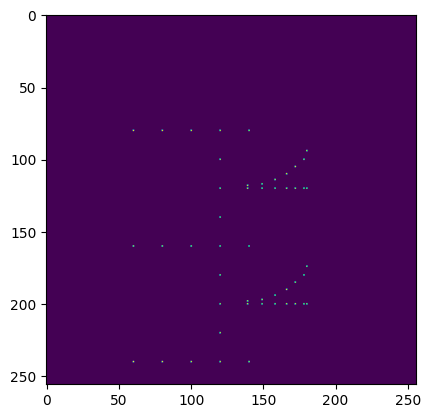

In [133]:
plt.imshow(test_reconstruction.phantom.mask[:,:,0])

In [142]:
np.where(test_reconstruction.phantom.mask[:,:,0])

(array([ 80,  80,  80,  80,  80,  94, 100, 100, 105, 110, 114, 117, 118,
        120, 120, 120, 120, 120, 120, 120, 120, 140, 160, 160, 160, 160,
        160, 174, 180, 180, 185, 190, 194, 197, 198, 200, 200, 200, 200,
        200, 200, 200, 200, 220, 240, 240, 240, 240, 240]),
 array([ 60,  80, 100, 120, 140, 180, 120, 178, 172, 166, 158, 149, 139,
        120, 139, 149, 158, 166, 172, 178, 180, 120,  60,  80, 100, 120,
        140, 180, 120, 178, 172, 166, 158, 149, 139, 120, 139, 149, 158,
        166, 172, 178, 180, 120,  60,  80, 100, 120, 140]))

In [2]:
from core.analytic_wave import planewave_pmax

In [3]:
test_experiment = experiment.Experiment.load('sequential_aperture_resolution')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)
/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


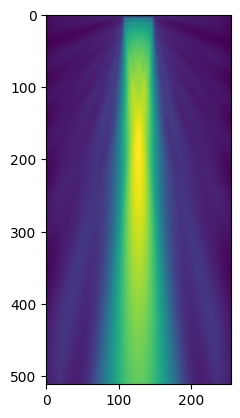

In [4]:
pmax = planewave_pmax(resolution=0.00025, 
                          matrix_size=(256,512), 
                          L=10e-3, 
                          f=1e6, 
                          m=[-2,-1,0,1,2], 
                          w=10e-3 / 32, 
                          c_0=1500, 
                          rho_0=1000, 
                          v_0=5e-8, 
                          tau=1, 
                          t=np.linspace(0, 20, 200), 
                          omega_c=1)

plt.imshow(pmax)

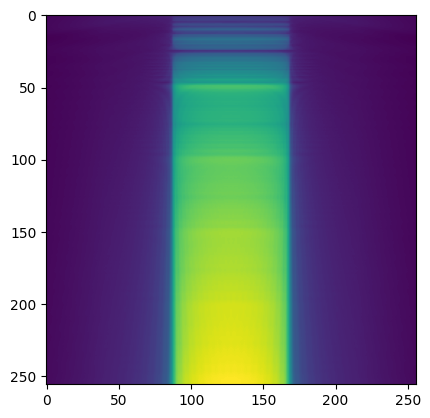

In [16]:
pmax = planewave_pmax(resolution=0.0005, 
                    matrix_size=(256,256), 
                    L=test_reconstruction.transducer_set[0][0].width, 
                    f=test_reconstruction.transducer_set[0][0].max_frequency, 
                    m=[-2,-1,0,1,2], 
                    w=test_reconstruction.transducer_set[0][0].width / test_reconstruction.transducer_set[0][0].get_num_elements(), 
                    c_0=1500, 
                    rho_0=1000, 
                    v_0=5e-8, 
                    tau=1, 
                    t=np.linspace(0, 10, 100), 
                    omega_c=1)

plt.imshow(pmax)

In [6]:
images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False, pressure_field=pmax, pressure_field_resolution=0.0005)

100%|██████████| 15/15 [00:00<00:00, 395689.06it/s]


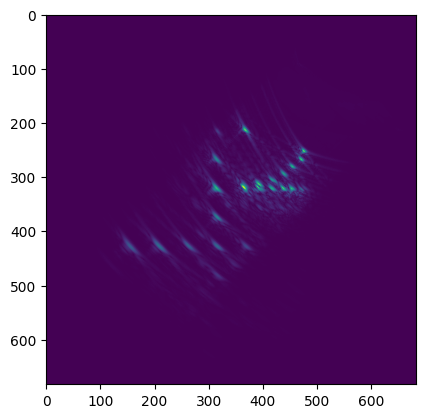

In [7]:
plt.imshow(images1[0][:,:,0])

In [8]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)/(len(images1)//3)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)/(len(images1)//3)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)/(len(images1)//3)

In [9]:
from scipy.interpolate import NearestNDInterpolator
sensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(sensor.shape[0])):
    for j in range(sensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(sensor[i,j,:].sum(axis=-1))
X = np.linspace(0, sensor.shape[0], image1.shape[0])
Y = np.linspace(0, sensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,228:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:228] = 0
sensor_mask2[:,456:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:456] = 0

100%|██████████| 256/256 [00:00<00:00, 2788.77it/s]


/tmp/ipykernel_4154316/3891532706.py:5: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image1t1 / np.max(image1t1))
/tmp/ipykernel_4154316/3891532706.py:22: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image1t3 / np.max(image1t3))


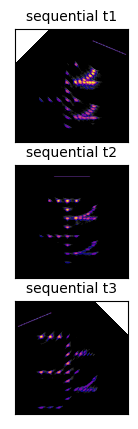

In [10]:
fig, ax = plt.subplots(3,1, figsize=(2.5,5))
contour_cmap = plt.cm.get_cmap('plasma')

# psf = 20 * np.log10(image1t1 / 1000000)
psf = 20 * np.log10(image1t1 / np.max(image1t1))

image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[0].set_title('sequential t1', fontsize=10)

# psf = 20 * np.log10(image1t2 / 1000000)
psf = 20 * np.log10(image1t2 / np.max(image1t2))
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[1].set_title('sequential t2', fontsize=10)

# psf = 20 * np.log10(image1t3 / 1000000)
psf = 20 * np.log10(image1t3 / np.max(image1t3))
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[2].set_title('sequential t3', fontsize=10)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_individual_resolution_apodized.png', dpi=300, bbox_inches="tight")

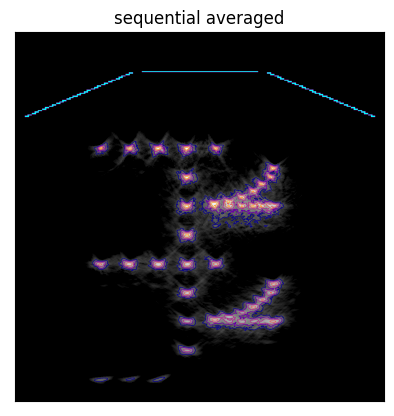

In [13]:
# psf = 20 * np.log10(image1 / 1000000)
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-35, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5,0])

ax.set_title('sequential averaged')

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig('sequential_aperture_resolution_apodized.png', dpi=300, bbox_inches="tight")